In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#For Evaluating models.
import eli5
from eli5.sklearn import PermutationImportance



In [2]:
#import data
leie = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/UPDATED.csv', low_memory=False)
dmepos = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/mup_dme_ry21_p05_v10_dy19_prvhpr_0.csv', low_memory=False)
partb = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formB_MUP_PHY_R21_P04_V10_D19_Prov_Svc.csv', encoding = "ISO-8859-1", low_memory=False)
partd = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formD_MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv', encoding = "ISO-8859-1", low_memory=False)

In [3]:
partb.rename(columns = {'Rndrng_NPI':'npi'}, inplace = True)
partd.rename(columns = {'Prscrbr_NPI':'npi'}, inplace = True)
dmepos.rename(columns = {'Rfrg_NPI':'npi'}, inplace = True)

In [4]:
#list of the most relevant features of each table
partb_feats = ['npi', 'HCPCS_Cd', 'HCPCS_Desc', 'HCPCS_Drug_Ind', 'Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr', 'Tot_Srvcs', 'Tot_Benes', 'Tot_Bene_Day_Srvcs', 'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Pymt_Amt']
partd_feats = ['npi', 'Prscrbr_Type', 'Tot_Benes', 'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst']
dmepos_feats = ['npi', 'Rfrg_Prvdr_Type', 'Rfrg_Prvdr_Gndr', 'Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Pymt_Amt']

In [5]:
#create new tables with relevant features
partb_features = partb[partb_feats]
partd_features = partd[partd_feats]
dmepos_features = dmepos[dmepos_feats]

In [6]:
#preprocess data set B

partb_features = partb_features[partb_features.HCPCS_Drug_Ind.eq('N')]
partb_features.head(5).iloc[1]
partb_features = partb_features.groupby(['npi','Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr']).agg({'Tot_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                                     'Tot_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                                     'Tot_Bene_Day_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                                     'Avg_Sbmtd_Chrg':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                                     'Avg_Mdcr_Pymt_Amt': ['sum', 'mean', 'median', np.std, 'min', 'max']})
partb_features.columns = ['_'.join(col) for col in partb_features.columns.values]
partb_features.isna().sum()
partb_features.fillna(0, inplace=True)
partb_features = partb_features.reset_index(level=['npi', 'Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr'])


In [7]:
#preprocess data set D
partd_features.columns
partd_features.bene_count = partd_features.Tot_Benes.replace(0,5)
partd_features = partd_features.groupby(['npi','Prscrbr_Type']).agg({'Tot_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                     'Tot_Clms':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                     'Tot_30day_Fills':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                     'Tot_Day_Suply':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                     'Tot_Drug_Cst': ['sum', 'mean', 'median', np.std, 'min', 'max']})
partd_features.columns = ['_'.join(col) for col in partd_features.columns.values]
partd_features = partd_features.reset_index(level=['Prscrbr_Type', 'npi'])

In [8]:
#preprocess DMEPOS 
dmepos_features.columns
dmepos_features.NUMBER_OF_SUPPLIER_BENEFICIARIES = dmepos_features.Tot_Suplr_Benes.replace(0,5)
dmepos_features = dmepos_features.groupby(['npi','Rfrg_Prvdr_Type', 
                         'Rfrg_Prvdr_Gndr']).agg({'Tot_Suplrs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                 'Tot_Suplr_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                 'Tot_Suplr_Clms':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                 'Tot_Suplr_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                 'Avg_Suplr_Mdcr_Pymt_Amt':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                                 'Avg_Suplr_Sbmtd_Chrg': ['sum', 'mean', 'median', np.std, 'min', 'max']})
dmepos_features.columns = ['_'.join(col) for col in dmepos_features.columns.values]
dmepos_features = dmepos_features.reset_index(level=['Rfrg_Prvdr_Type', 'npi', 'Rfrg_Prvdr_Gndr'])
#######

In [9]:
leie.rename(columns = {'NPI':'npi'}, inplace = True)

In [10]:
#merge 3 data sets with LEIE on NPI
partb = pd.merge(leie, partb_features, on='npi', how='outer')
partd = pd.merge(leie, partd_features, on='npi', how='outer')
dmepos = pd.merge(leie, dmepos_features, on='npi', how='outer')

In [11]:
partb = partb[['npi', 'Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr', 'Tot_Srvcs_sum',
       'Tot_Srvcs_mean', 'Tot_Srvcs_median', 'Tot_Srvcs_std',
       'Tot_Srvcs_min', 'Tot_Srvcs_max', 'Tot_Benes_sum',
       'Tot_Benes_mean', 'Tot_Benes_median', 'Tot_Benes_std',
       'Tot_Benes_min', 'Tot_Benes_max', 'Tot_Bene_Day_Srvcs_sum',
       'Tot_Bene_Day_Srvcs_mean', 'Tot_Bene_Day_Srvcs_median',
       'Tot_Bene_Day_Srvcs_std', 'Tot_Bene_Day_Srvcs_min',
       'Tot_Bene_Day_Srvcs_max', 'Avg_Sbmtd_Chrg_sum',
       'Avg_Sbmtd_Chrg_mean', 'Avg_Sbmtd_Chrg_median',
       'Avg_Sbmtd_Chrg_std', 'Avg_Sbmtd_Chrg_min',
       'Avg_Sbmtd_Chrg_max', 'Avg_Mdcr_Pymt_Amt_sum',
       'Avg_Mdcr_Pymt_Amt_mean',
       'Avg_Mdcr_Pymt_Amt_median',
       'Avg_Mdcr_Pymt_Amt_std', 'Avg_Mdcr_Pymt_Amt_min',
       'Avg_Mdcr_Pymt_Amt_max', 'EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE']]

In [12]:
partd = partd[['npi', 'Prscrbr_Type', 'Tot_Benes_sum', 'Tot_Benes_mean', 'Tot_Benes_median',
       'Tot_Benes_std', 'Tot_Benes_min', 'Tot_Benes_max',
       'Tot_Clms_sum', 'Tot_Clms_mean',
       'Tot_Clms_median', 'Tot_Clms_std',
       'Tot_Clms_min', 'Tot_Clms_max',
       'Tot_30day_Fills_sum', 'Tot_30day_Fills_mean',
       'Tot_30day_Fills_median', 'Tot_30day_Fills_std',
       'Tot_30day_Fills_min', 'Tot_30day_Fills_max',
       'Tot_Day_Suply_sum', 'Tot_Day_Suply_mean',
       'Tot_Day_Suply_median', 'Tot_Day_Suply_std',
       'Tot_Day_Suply_min', 'Tot_Day_Suply_max', 'Tot_Drug_Cst_sum',
       'Tot_Drug_Cst_mean', 'Tot_Drug_Cst_median', 'Tot_Drug_Cst_std',
       'Tot_Drug_Cst_min', 'Tot_Drug_Cst_max', 'EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE']]

In [13]:
dmepos = dmepos[['npi','EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE', 'Rfrg_Prvdr_Type',
       'Rfrg_Prvdr_Gndr', 'Tot_Suplrs_sum', 'Tot_Suplrs_mean',
       'Tot_Suplrs_median', 'Tot_Suplrs_std', 'Tot_Suplrs_min',
       'Tot_Suplrs_max', 'Tot_Suplr_Benes_sum', 'Tot_Suplr_Benes_mean',
       'Tot_Suplr_Benes_median', 'Tot_Suplr_Benes_std', 'Tot_Suplr_Benes_min',
       'Tot_Suplr_Benes_max', 'Tot_Suplr_Clms_sum', 'Tot_Suplr_Clms_mean',
       'Tot_Suplr_Clms_median', 'Tot_Suplr_Clms_std', 'Tot_Suplr_Clms_min',
       'Tot_Suplr_Clms_max', 'Tot_Suplr_Srvcs_sum', 'Tot_Suplr_Srvcs_mean',
       'Tot_Suplr_Srvcs_median', 'Tot_Suplr_Srvcs_std', 'Tot_Suplr_Srvcs_min',
       'Tot_Suplr_Srvcs_max', 'Avg_Suplr_Mdcr_Pymt_Amt_sum',
       'Avg_Suplr_Mdcr_Pymt_Amt_mean', 'Avg_Suplr_Mdcr_Pymt_Amt_median',
       'Avg_Suplr_Mdcr_Pymt_Amt_std', 'Avg_Suplr_Mdcr_Pymt_Amt_min',
       'Avg_Suplr_Mdcr_Pymt_Amt_max', 'Avg_Suplr_Sbmtd_Chrg_sum',
       'Avg_Suplr_Sbmtd_Chrg_mean', 'Avg_Suplr_Sbmtd_Chrg_median',
       'Avg_Suplr_Sbmtd_Chrg_std', 'Avg_Suplr_Sbmtd_Chrg_min',
       'Avg_Suplr_Sbmtd_Chrg_max']]

In [14]:
#remove all rows without npi or provider info
partb = partb[(partb.npi != 0) & (partb.Rndrng_Prvdr_Type)]
partd = partd[(partd.npi != 0) & (partd.Prscrbr_Type)]
dmepos = dmepos[(dmepos.npi != 0) & (dmepos.Rfrg_Prvdr_Type)]

In [15]:
#add the label column
partb['TARGET'] = '0'
partd['TARGET'] = '0'
dmepos['TARGET'] = '0'

In [16]:
partb['EXCLDATE'] = partb['EXCLDATE'].fillna(20500101).astype(int)
partb['START_EXCLDATE'] = pd.to_datetime(partb['EXCLDATE'], format= '%Y%m%d' )
partb.head()

,npi,Rndrng_Prvdr_Type,Rndrng_Prvdr_Gndr,Tot_Srvcs_sum,Tot_Srvcs_mean,Tot_Srvcs_median,Tot_Srvcs_std,Tot_Srvcs_min,Tot_Srvcs_max,Tot_Benes_sum,...,Avg_Mdcr_Pymt_Amt_std,Avg_Mdcr_Pymt_Amt_min,Avg_Mdcr_Pymt_Amt_max,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE,TARGET,START_EXCLDATE
70159,1124292966,Rheumatology,M,680.0,113.333333,98.0,91.698782,16.0,231.0,281.0,...,39.129903,14.390000,123.099078,1128a1,20200618,0.0,0.0,NaN,0,2020-06-18
70160,1679754725,Nephrology,M,2502.0,192.461538,38.0,326.925735,11.0,1147.0,951.0,...,48.399650,22.933636,183.028182,1128b7,20200422,0.0,0.0,NaN,0,2020-04-22
70163,1912929787,Podiatry,M,36.0,36.000000,36.0,0.000000,36.0,36.0,24.0,...,0.000000,15.923611,15.923611,1128a4,20220720,0.0,0.0,NaN,0,2022-07-20
70174,1891887048,Anesthesiology,M,11273.0,939.416667,130.0,1727.399804,21.0,5798.0,2868.0,...,39.821169,16.350000,150.724020,1128a1,20220320,0.0,0.0,NaN,0,2022-03-20
70202,1972548618,Nephrology,M,205.0,68.333333,89.0,45.654500,16.0,100.0,113.0,...,12.806940,24.698125,50.312000,1128a4,20201020,0.0,0.0,NaN,0,2020-10-20


In [17]:
partb['START_EXCLDATE'] = partb['START_EXCLDATE'].dt.year

In [18]:
partd['EXCLDATE'] = partd['EXCLDATE'].fillna(20500101).astype(int)
partd['START_EXCLDATE'] = pd.to_datetime(partd['EXCLDATE'], format= '%Y%m%d' )
partd['START_EXCLDATE'] = partd['START_EXCLDATE'].dt.year

In [19]:
dmepos['EXCLDATE'] = dmepos['EXCLDATE'].fillna(20500101).astype(int)
dmepos['START_EXCLDATE'] = pd.to_datetime(dmepos['EXCLDATE'], format= '%Y%m%d' )
dmepos['START_EXCLDATE'] = dmepos['START_EXCLDATE'].dt.year

In [20]:
#define the labeling function
def make_labels(data_yr):
    if data_yr < 2025:
        return 'FRAUD'
    else:
        return 'NOT_FRAUD'
        

In [21]:
#apply the labeling function to data sets
partb['TARGET'] = partb[["START_EXCLDATE"]].apply(lambda x: make_labels(*x), axis=1)
partd['TARGET'] = partd[["START_EXCLDATE"]].apply(lambda x: make_labels(*x), axis=1)
dmepos['TARGET'] = dmepos[["START_EXCLDATE"]].apply(lambda x: make_labels(*x), axis=1)

In [22]:
#create the combined data set
combined = pd.merge(partb,partd, left_on=['npi', 'Rndrng_Prvdr_Type'], right_on=['npi', 'Prscrbr_Type']).merge(dmepos, left_on=['npi', 'Rndrng_Prvdr_Type'],right_on=['npi','Rfrg_Prvdr_Type'])
#drop one gender column (which is duplicate)
combined.drop(columns=['Rfrg_Prvdr_Gndr','EXCLTYPE_y',
 'EXCLDATE_y','REINDATE_y','WAIVERDATE_y','WVRSTATE_y', 'Prscrbr_Type','EXCLTYPE_x',
 'EXCLDATE_x', 'REINDATE_x', 'WAIVERDATE_x', 'WVRSTATE_x','Rfrg_Prvdr_Type', 'TARGET_x', 'TARGET_y', 'START_EXCLDATE_x', 'START_EXCLDATE_y'],
              inplace=True) 
combined.head()

,npi,Rndrng_Prvdr_Type,Rndrng_Prvdr_Gndr,Tot_Srvcs_sum,Tot_Srvcs_mean,Tot_Srvcs_median,Tot_Srvcs_std,Tot_Srvcs_min,Tot_Srvcs_max,Tot_Benes_sum_x,...,Avg_Suplr_Mdcr_Pymt_Amt_min,Avg_Suplr_Mdcr_Pymt_Amt_max,Avg_Suplr_Sbmtd_Chrg_sum,Avg_Suplr_Sbmtd_Chrg_mean,Avg_Suplr_Sbmtd_Chrg_median,Avg_Suplr_Sbmtd_Chrg_std,Avg_Suplr_Sbmtd_Chrg_min,Avg_Suplr_Sbmtd_Chrg_max,TARGET,START_EXCLDATE
0,1912929787,Podiatry,M,36.0,36.000000,36.0,0.000000,36.0,36.0,24.0,...,85.629703,1036.032954,4736.338735,789.389789,723.091631,489.039116,131.493366,1539.916591,FRAUD,2022
1,1114964442,Cardiology,M,3835.0,153.400000,66.0,194.501714,15.0,852.0,2785.0,...,0.030328,58.421000,1390.825767,99.344698,83.241429,98.468612,0.239754,323.687857,FRAUD,2020
2,1427138510,Family Practice,M,953.0,95.300000,22.0,159.870121,11.0,519.0,386.0,...,1.619600,40.461111,579.159839,72.394980,54.876000,63.130810,8.891520,204.313333,FRAUD,2022
3,1558562363,Emergency Medicine,M,268.0,53.600000,21.0,70.461337,15.0,179.0,263.0,...,37.264597,925.661112,8041.634058,804.163406,945.351344,463.080547,59.549516,1442.954648,FRAUD,2021
4,1689676264,Infectious Disease,M,119.0,39.666667,41.0,21.031722,18.0,60.0,114.0,...,31.464167,96.809167,313.940000,156.970000,156.970000,123.418418,69.700000,244.240000,FRAUD,2022


In [23]:
#one hot encoding of categorical variables
partb_category_columns = ['Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr']
partd_category_columns = ['Prscrbr_Type']
dmepos_category_columns = ['Rfrg_Prvdr_Gndr', 'Rfrg_Prvdr_Type']
combined_category_columns = ['Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr']

In [24]:
partb = pd.get_dummies(partb, columns=partb_category_columns, drop_first=True)
partd = pd.get_dummies(partd, columns=partd_category_columns, drop_first=True)
dmepos = pd.get_dummies(dmepos, columns=dmepos_category_columns, drop_first=True)
combined = pd.get_dummies(combined, columns=combined_category_columns, drop_first=True)

In [25]:
#drop all unneccessary columns
columns_to_drop = [ 'EXCLTYPE','EXCLDATE','REINDATE','WAIVERDATE',
                   'WVRSTATE', 'npi', 'START_EXCLDATE']

partb.drop(columns_to_drop, axis=1, inplace=True)
partd.drop(columns_to_drop, axis=1, inplace=True)
dmepos.drop(columns_to_drop, axis=1, inplace=True)
combined.drop(columns_to_drop, axis=1, inplace=True)

In [26]:
#fill NaN value with 0
partb.fillna(0, inplace = True)
partd.fillna(0, inplace=True)
dmepos.fillna(0, inplace=True)
combined.fillna(0, inplace=True)

So we are done with data preprocessing. Now come the model

In [27]:
#making targets binary
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
dmepos.TARGET = dmepos.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
combined.TARGET = combined.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

In [28]:
#split data set into features and label
# partb dataset
X_partb = partb.drop(columns=['TARGET'], axis=1)
y_partb = partb.TARGET

#partd dataset
X_partd = partd.drop(columns=['TARGET'], axis=1)
y_partd = partd.TARGET

#dmepos dataset
X_dmepos = dmepos.drop(columns=['TARGET'], axis=1)
y_dmepos = dmepos.TARGET

#combined dataset
X_combined = combined.drop(columns=['TARGET'], axis=1)
y_combined = combined.TARGET

In [29]:
#downsampling
rus1 = RandomUnderSampler(random_state=42)
X_partb, y_partb = rus1.fit_resample(X_partb, y_partb)

rus2 = RandomUnderSampler(random_state=42)
X_partd, y_partd = rus2.fit_resample(X_partd, y_partd)

rus3 = RandomUnderSampler(random_state=42)
X_dmepos, y_dmepos = rus3.fit_resample(X_dmepos, y_dmepos)

rus4 = RandomUnderSampler(random_state=42)
X_combined, y_combined = rus4.fit_resample(X_combined, y_combined)

In [30]:
#split data set into train and test set
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_partd, y_partd, test_size=0.2, random_state=0)
X_train_dmepos, X_test_dmepos, y_train_dmepos, y_test_dmepos = train_test_split(X_dmepos, y_dmepos, test_size=0.2, random_state=0)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=0)

In [31]:
#scale the data
partb_feature_names = X_partb.columns.to_list()

X_partb_scaler = StandardScaler()
X_partb_scaled = X_partb_scaler.fit_transform(X_train_b) #Fit/Transform to the training data


X_train_b = pd.DataFrame(X_partb_scaled, columns=partb_feature_names)

X_test_b = pd.DataFrame(X_partb_scaler.transform(X_test_b), columns=partb_feature_names) #Transform the test set with fitted scaler.

In [32]:
partd_feature_names = X_partd.columns.to_list()

X_partd_scaler = StandardScaler()
X_partd_scaled = X_partd_scaler.fit_transform(X_train_d)

X_train_d = pd.DataFrame(X_partd_scaled, columns=partd_feature_names)
X_test_d = pd.DataFrame(X_partd_scaler.transform(X_test_d), columns=partd_feature_names)


In [33]:
dmepos_feature_names = X_dmepos.columns.to_list()

X_dmepos_scaler = StandardScaler()
X_dmepos_scaled = X_dmepos_scaler.fit_transform(X_train_dmepos)

X_train_dmepos = pd.DataFrame(X_dmepos_scaled, columns=dmepos_feature_names)
X_test_dmepos = pd.DataFrame(X_dmepos_scaler.transform(X_test_dmepos), columns=dmepos_feature_names)

In [34]:
combined_feature_names = X_combined.columns.to_list()

X_combined_scaler = StandardScaler()
X_combined_scaled = X_combined_scaler.fit_transform(X_train_combined)

X_train_combined = pd.DataFrame(X_combined_scaled, columns=combined_feature_names)
X_test_combined = pd.DataFrame(X_combined_scaler.transform(X_test_combined), columns = combined_feature_names)

In [35]:
#Now we apply logistic regression
logreg_b = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_d = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_dmepos = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_combined = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')

In [36]:
param_grid_logreg = {  
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.01, .05, .001],
}

In [37]:
grid_tree_logreg_b = RandomizedSearchCV(logreg_b, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_d = RandomizedSearchCV(logreg_d, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_dmepos = RandomizedSearchCV(logreg_dmepos, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_combined = RandomizedSearchCV(logreg_combined, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [38]:
#fit the models to the training data
grid_tree_logreg_b.fit(X_train_b, y_train_b)
grid_tree_logreg_d.fit(X_train_d, y_train_d)
grid_tree_logreg_dmepos.fit(X_train_dmepos, y_train_dmepos)
grid_tree_logreg_combined.fit(X_train_combined, y_train_combined)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                                solver='saga'),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.001],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='f1')

In [39]:
grid_tree_logreg_combined.best_params_

{'penalty': 'l2', 'C': 0.01}

In [40]:
#predict on the test set
y_pred_b = grid_tree_logreg_b.predict(X_test_b)
y_pred_d = grid_tree_logreg_d.predict(X_test_d)
y_pred_dmepos = grid_tree_logreg_dmepos.predict(X_test_dmepos)
y_pred_combined = grid_tree_logreg_combined.predict(X_test_combined)

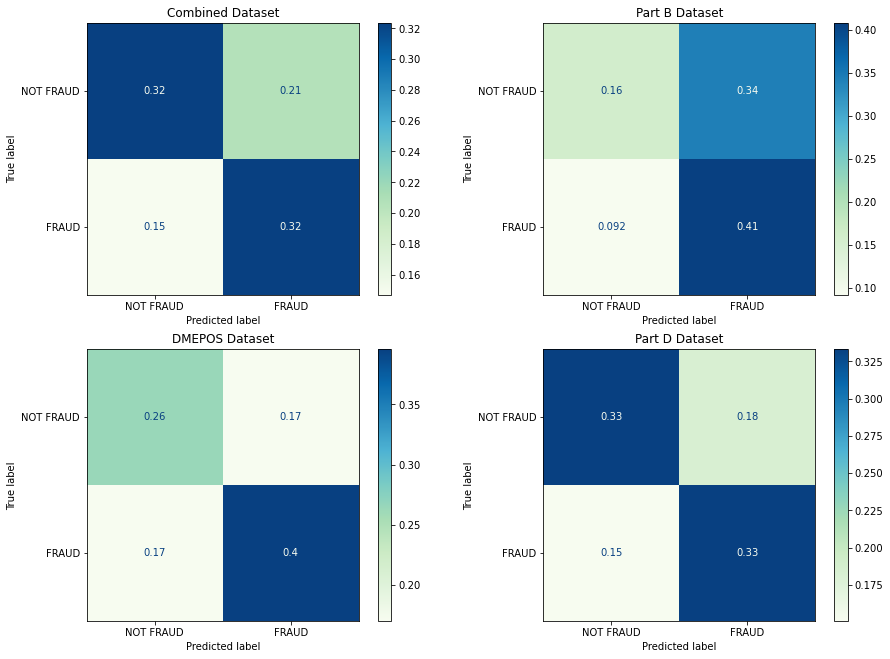

In [41]:
#evaluate performance
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(grid_tree_logreg_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(grid_tree_logreg_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(grid_tree_logreg_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_dmepos = metrics.plot_confusion_matrix(grid_tree_logreg_dmepos, X_test_dmepos, y_test_dmepos, cmap= "GnBu", ax = ax[1,0], normalize='all')
ax[1,0].set_title('DMEPOS Dataset')
ax[1,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,0].set_yticklabels(['NOT FRAUD','FRAUD']);



fig.savefig('logreg_confusion.png')

We can see from the ROC curves below that the Combined dataset performs the best.


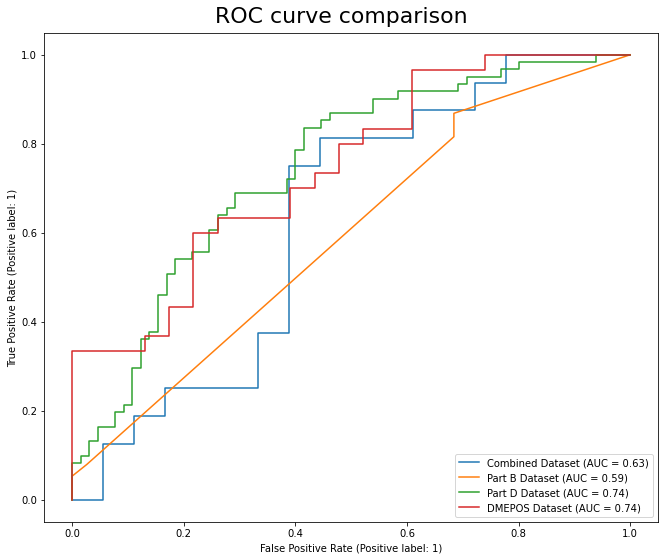

In [42]:
#plot ROC
ROC_combined = metrics.plot_roc_curve(grid_tree_logreg_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(grid_tree_logreg_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(grid_tree_logreg_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)
ROC_dmepos = metrics.plot_roc_curve(grid_tree_logreg_dmepos, X_test_dmepos, y_test_dmepos, name="DMEPOS Dataset", ax = ROC_combined.ax_)
ROC_dmepos.figure_.suptitle("ROC curve comparison", y=.92, size=22);
ROC_combined.figure_.set_size_inches(11,9)
print("We can see from the ROC curves below that the Combined dataset performs the best.")
plt.savefig('logreg_ROC.png')

In [43]:
#features importance using eli5
log_perm = PermutationImportance(grid_tree_logreg_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Logistic Regression Feature Importances:')
eli5.show_weights(log_perm, feature_names=combined_feature_names)

Logistic Regression Feature Importances:


Weight,Feature
0.0196 ± 0.0201,Tot_Suplr_Srvcs_max
0.0182 ± 0.0227,Rndrng_Prvdr_Gndr_M
0.0141 ± 0.0234,Rndrng_Prvdr_Type_General Practice
0.0113 ± 0.0075,Tot_Suplr_Srvcs_std
0.0109 ± 0.0133,Rndrng_Prvdr_Type_Family Practice
0.0102 ± 0.0335,Tot_Benes_sum_x
0.0101 ± 0.0114,Rndrng_Prvdr_Type_Infectious Disease
0.0101 ± 0.0136,Rndrng_Prvdr_Type_Pain Management
0.0094 ± 0.0197,Tot_30day_Fills_max
0.0086 ± 0.0172,Avg_Suplr_Mdcr_Pymt_Amt_max


In [44]:
#try random forest 
rf_b = RandomForestClassifier(n_jobs=-1)
rf_d = RandomForestClassifier(n_jobs=-1)
rf_dmepos = RandomForestClassifier(n_jobs=-1)
rf_combined = RandomForestClassifier(n_jobs=-1)

In [45]:
param_grid_rf = {  
    'n_estimators': list(range(1,2000)),
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,50)),
    'min_samples_leaf': list(range(1,50,1)),
}

In [46]:
tree_rf_b = RandomizedSearchCV(rf_b, 
                                  param_grid_rf, 
                                  cv=5,
                                  verbose=1,
                                  scoring='f1')

tree_rf_d = RandomizedSearchCV(rf_d, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

tree_rf_dmepos = RandomizedSearchCV(rf_dmepos, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

tree_rf_combined = RandomizedSearchCV(rf_combined, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [47]:
tree_rf_b.fit(X_train_b, y_train_b)
tree_rf_d.fit(X_train_d, y_train_d)
tree_rf_dmepos.fit(X_train_dmepos, y_train_dmepos)
tree_rf_combined.fit(X_train_combined, y_train_combined)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   scoring='f1')

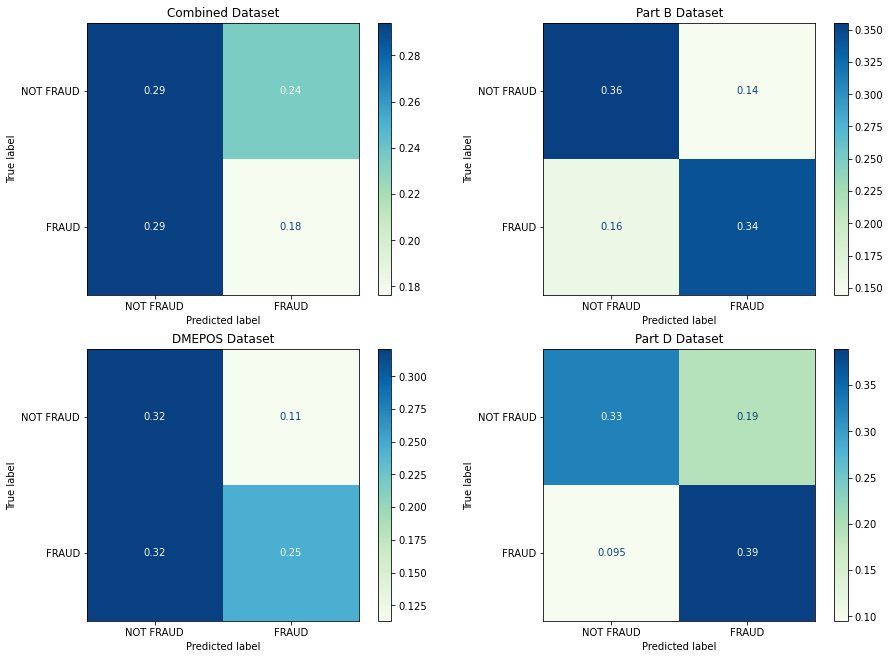

In [48]:
#evaluate performance of random forest
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(tree_rf_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(tree_rf_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(tree_rf_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_dmepos = metrics.plot_confusion_matrix(tree_rf_dmepos, X_test_dmepos, y_test_dmepos, cmap= "GnBu", ax = ax[1,0], normalize='all')
ax[1,0].set_title('DMEPOS Dataset')
ax[1,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,0].set_yticklabels(['NOT FRAUD','FRAUD']);


fig.savefig('forest_confusion.png')

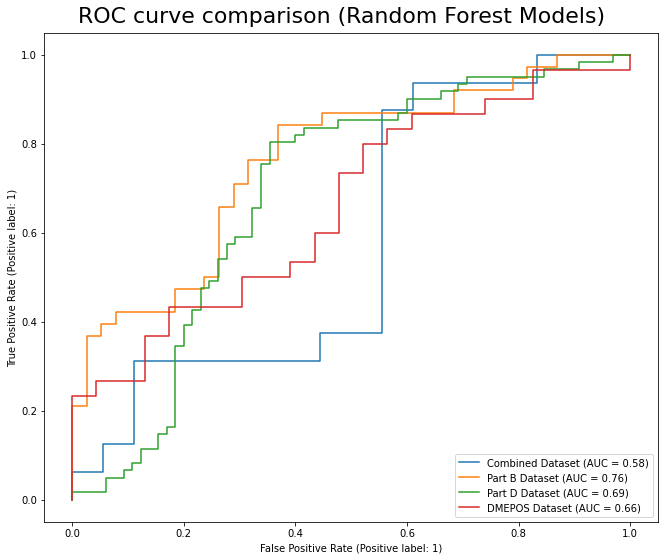

In [49]:
ROC_combined = metrics.plot_roc_curve(tree_rf_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(tree_rf_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(tree_rf_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)
ROC_dmepos = metrics.plot_roc_curve(tree_rf_dmepos, X_test_dmepos, y_test_dmepos, name="DMEPOS Dataset", ax = ROC_combined.ax_)
ROC_dmepos.figure_.suptitle("ROC curve comparison (Random Forest Models)", y=.92, size=22);
ROC_combined.figure_.set_size_inches(11,9)
plt.savefig('randforest_ROC.png')

In [50]:
#feature importance
tree_perm = PermutationImportance(tree_rf_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Random Forest Feature Importances:')
eli5.show_weights(tree_perm, feature_names=combined_feature_names)

Random Forest Feature Importances:


Weight,Feature
0.0072 ± 0.0000,Avg_Mdcr_Pymt_Amt_median
0 ± 0.0000,Tot_30day_Fills_max
0 ± 0.0000,Tot_Drug_Cst_max
0 ± 0.0000,Tot_Drug_Cst_min
0 ± 0.0000,Tot_Drug_Cst_std
0 ± 0.0000,Tot_Drug_Cst_median
0 ± 0.0000,Tot_Drug_Cst_mean
0 ± 0.0000,Tot_Suplrs_mean
0 ± 0.0000,Tot_Day_Suply_max
0 ± 0.0000,Tot_30day_Fills_median
